In [3]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os

import torch
import torch.nn as nn

import onnx
from onnx_tf.backend import prepare

In [18]:
# hide stupid tf warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# model path
model_path = "../model/"

# model name
model_name_pt = "pytorch_nima_ps_v2_netg20200324-202041"

In [5]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      nn.ConvTranspose2d(in_channels=nz, 
                         out_channels=ngf*16, 
                         kernel_size=3, 
                         stride=1, 
                         padding=0, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*16),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*16, 
                         out_channels=ngf*8, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*8),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*8, 
                         out_channels=ngf*4, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*4),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*4, 
                         out_channels=ngf*2, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*2),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf*2, 
                         out_channels=ngf, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=ngf, 
                         out_channels=nc, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.Tanh()
    )
  def forward(self, input):
      return self.main(input)

In [6]:
# config device
device = torch.device("cpu")

# Create the generator
netG = Generator(0).to(device)

# output
print(netG)
print(sum(p.numel() for p in netG.parameters()))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [7]:
# load state dict
netG.load_state_dict(torch.load(os.path.join(model_path, model_name_pt), map_location=device))

<All keys matched successfully>

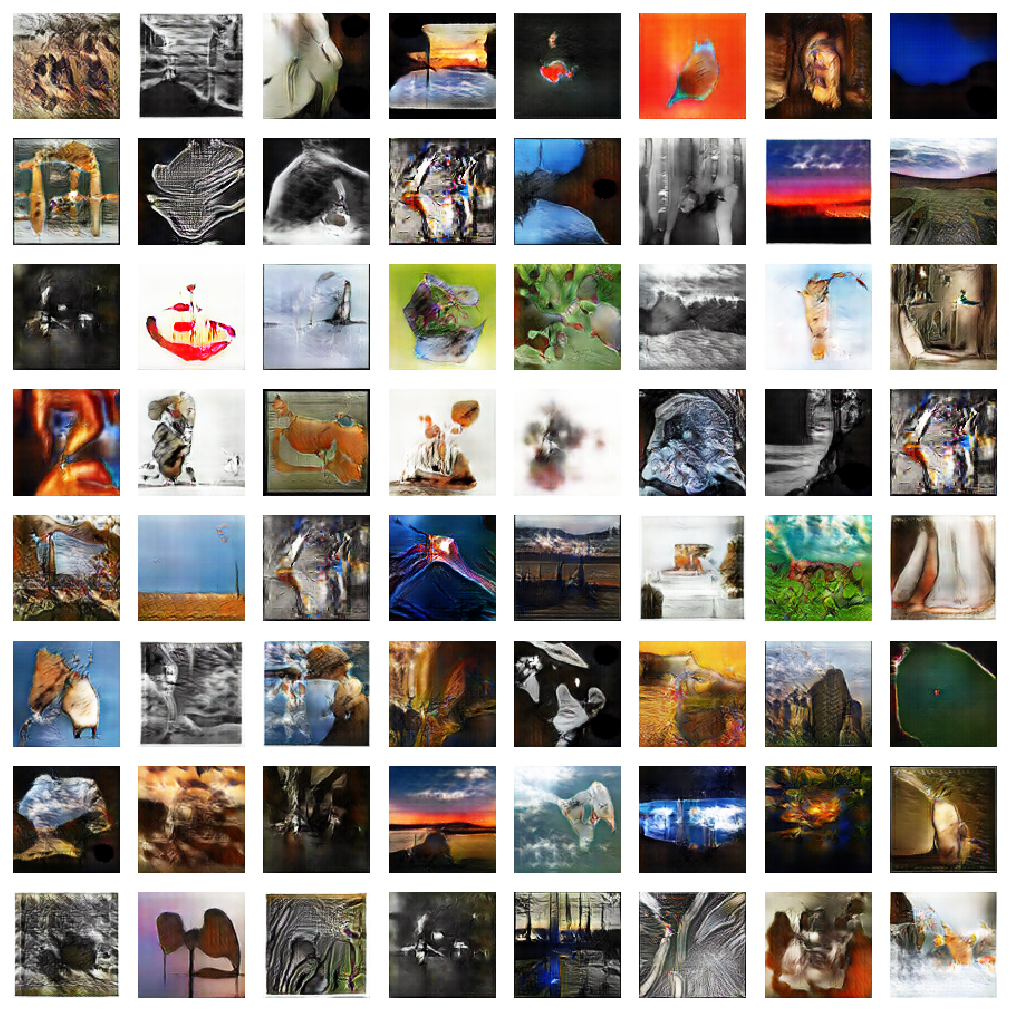

In [8]:
n_imgs = 64

# random input vector
noise = torch.randn(n_imgs, nz, 1, 1, device=device)
# generate images
img = netG(noise).detach().cpu()

# plot images
plt.figure(figsize=(math.ceil(math.sqrt(n_imgs)), math.ceil(math.sqrt(n_imgs))), dpi=128)
for i in range(n_imgs):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(np.transpose(img[i], (1,2,0))/2 + 0.5)
plt.tight_layout()
plt.show()

In [13]:
# now export to onnx
torch.onnx.export(netG, noise, os.path.join(model_path, model_name_pt + ".onnx"), verbose=True)

graph(%0 : Float(64, 100, 1, 1),
      %main.0.weight : Float(100, 1024, 3, 3),
      %main.1.weight : Float(1024),
      %main.1.bias : Float(1024),
      %main.1.running_mean : Float(1024),
      %main.1.running_var : Float(1024),
      %main.1.num_batches_tracked : Long(),
      %main.3.weight : Float(1024, 512, 4, 4),
      %main.4.weight : Float(512),
      %main.4.bias : Float(512),
      %main.4.running_mean : Float(512),
      %main.4.running_var : Float(512),
      %main.4.num_batches_tracked : Long(),
      %main.6.weight : Float(512, 256, 4, 4),
      %main.7.weight : Float(256),
      %main.7.bias : Float(256),
      %main.7.running_mean : Float(256),
      %main.7.running_var : Float(256),
      %main.7.num_batches_tracked : Long(),
      %main.9.weight : Float(256, 128, 4, 4),
      %main.10.weight : Float(128),
      %main.10.bias : Float(128),
      %main.10.running_mean : Float(128),
      %main.10.running_var : Float(128),
      %main.10.num_batches_tracked : Long(),


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


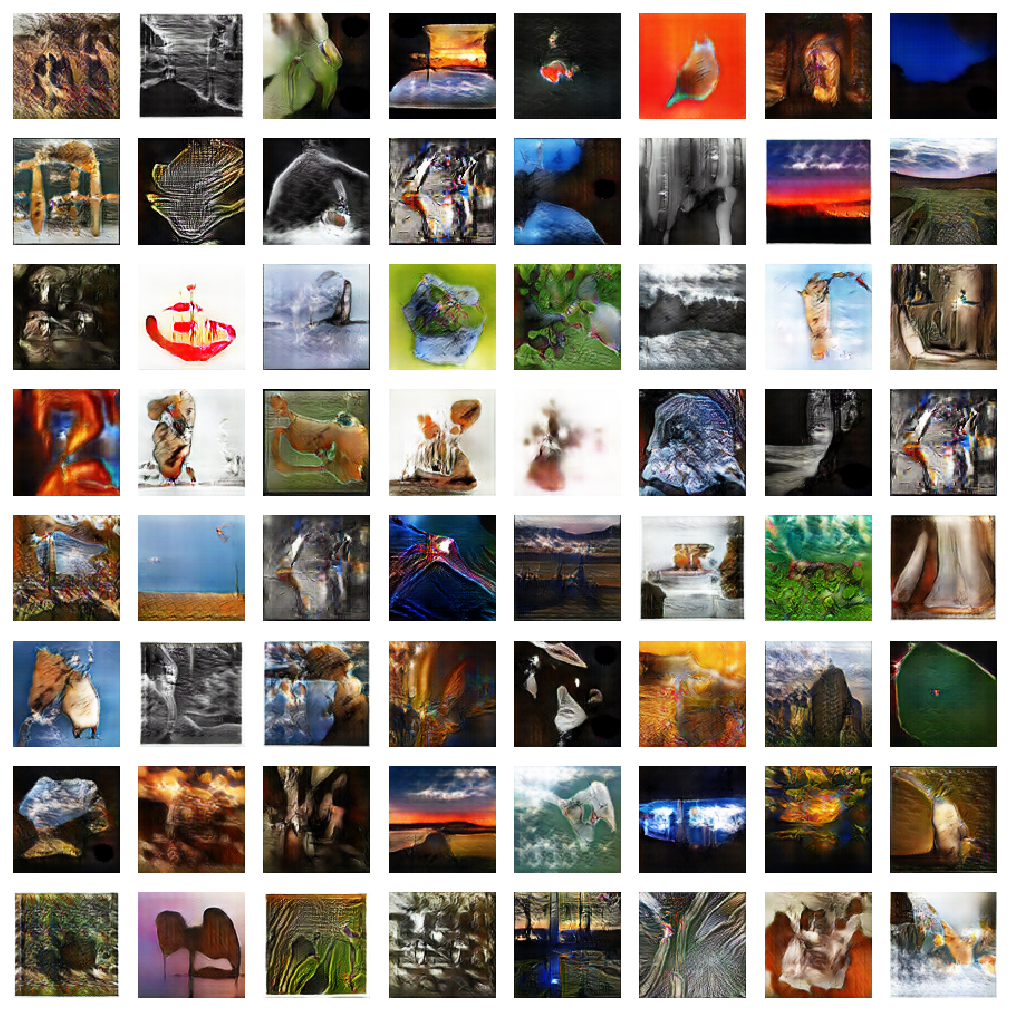

In [19]:
# load onnx model
onnx_model = onnx.load(os.path.join(model_path, model_name_pt + ".onnx"))

# run the loaded model
output = prepare(onnx_model).run(noise)  

# plot images
plt.figure(figsize=(math.ceil(math.sqrt(n_imgs)), math.ceil(math.sqrt(n_imgs))), dpi=128)
for i in range(n_imgs):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(np.transpose(output[0][i], (1,2,0))/2 + 0.5)
plt.tight_layout()
plt.show()